In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from vpl_model.networks import ContrastiveNet
from vpl_model.tasks import SemanticTask


In [2]:
np.random.seed(0)

# Testing all regimes for $\gamma$ and $\eta$

In [3]:
hidden_dim = 32
hierarchy_depth = 4
learning_rate = 0.01
weight_scale = 1e-10
batch_size = 2048
test_epochs = 10
epochs = 10000
run_test = False

all_regimes = {"contrastive_hebb": {"gamma": 1.0, "eta": 0.0},
               "gradient_descent": {"gamma": 0.0, "eta": 0.0},
               "quasi_predictive": {"gamma": -1.0, "eta": 0.0},
               "hebbian": {"gamma": 0, "eta": 1.0},
               "anti_hebbian": {"gamma": 0, "eta": -1.0},}

In [4]:
data = SemanticTask(batch_size=batch_size, h_levels=hierarchy_depth)

W1_0 = np.random.normal(scale = weight_scale, size=(hidden_dim, data.input_dim))
W2_0 = np.random.normal(scale = weight_scale, size=(data.output_dim, hidden_dim))

## Testing code

In [5]:
if run_test:
    for key, values in all_regimes.items():
        net = ContrastiveNet(W1_0=W1_0, W2_0=W2_0, gamma=values["gamma"], eta=values["eta"], learning_rate=learning_rate)
        for i in range(test_epochs):
            x, y = data.full_batch()
            h_ff, y_hat = net.forward(x)
            # print(h_ff.shape, y_hat.shape)
            net.update(x, y, y_hat, h_ff)
            net.loss(y_hat, y)
        print(key, "works fine :)")

# Reproducing fig 3 and 4

In [6]:
test_gammas = [-1.0, -0.5, -0.1, 0, 0.1, 0.5, 1.0]
test_etas = [-0.1, -0.05, -0.01, 0, 0.01, 0.05, 0.1]

In [7]:
gamma_results = []

for j, gamma in enumerate(test_gammas):
    net = ContrastiveNet(W1_0=W1_0, W2_0=W2_0, gamma=gamma, eta=0.0, learning_rate=learning_rate, lr_W2_W1=1.0)
    training_loss = []
    for i in tqdm(range(epochs)):
        x, y = data.full_batch()
        h_ff, y_hat = net.forward(x)
        net.update(x, y, y_hat, h_ff)
        training_loss.append(net.loss(y_hat, y))
    MDS = h_ff[:, :, 0] @ h_ff[:, :, 0].T/np.linalg.norm(h_ff[:, :, 0])
    gamma_results.append({"MDS": MDS, "loss": training_loss})

CUDA backend failed to initialize: Found cuDNN version 8201, but JAX was built against version 8906, which is newer. The copy of cuDNN that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
100%|██████████| 10000/10000 [00:18<00:00, 548.14it/s]


In [8]:
eta_results = []

for j, eta in enumerate(test_etas):
    net = ContrastiveNet(W1_0=W1_0, W2_0=W2_0, gamma=0.0, eta=eta, learning_rate=learning_rate, lr_W2_W1=1.0)
    training_loss = []
    for i in tqdm(range(epochs)):
        x, y = data.full_batch()
        h_ff, y_hat = net.forward(x)
        net.update(x, y, y_hat, h_ff)
        training_loss.append(net.loss(y_hat, y))
    MDS = h_ff[:, :, 0] @ h_ff[:, :, 0].T/np.linalg.norm(h_ff[:, :, 0])
    eta_results.append({"MDS": MDS, "loss": training_loss})

100%|██████████| 10000/10000 [00:18<00:00, 540.26it/s]


In [9]:
np.min(MDS)

Array(0.25573894, dtype=float32)

In [17]:
def training_panel(results, key):
    f, ax = plt.subplots(2, len(results), figsize=(3*len(results), 5))
    for i, r in enumerate(results):
        ax[0, i].plot(r["loss"])
        ax[1, i].imshow(r["MDS"], cmap="coolwarm")#, vmin=-1, vmax=1)
    plt.show()

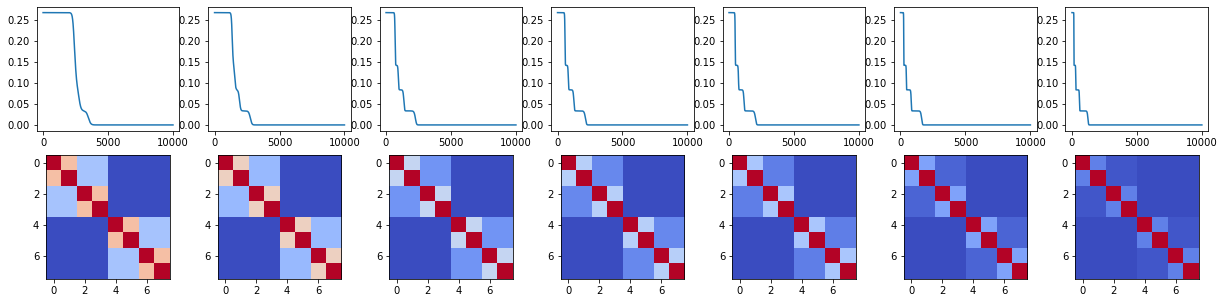

In [18]:
training_panel(results=gamma_results, key="gamma")

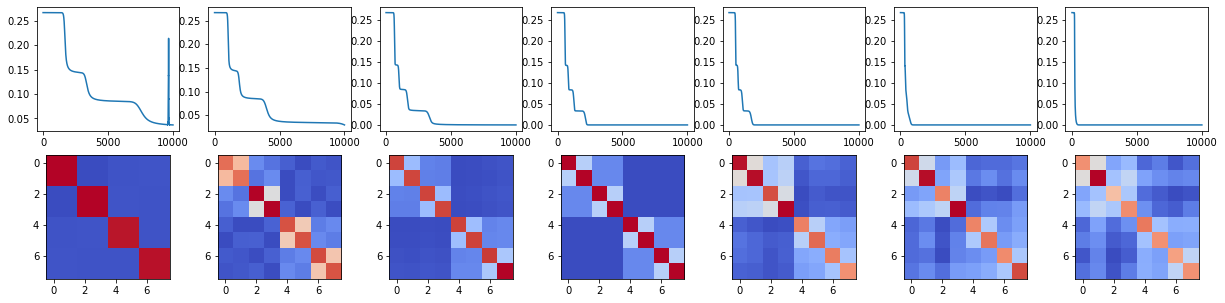

In [19]:
training_panel(results=eta_results, key="eta")
